In [1]:
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import pandas as pd

from metpy.calc import wind_components
from metpy.plots import StationPlot, StationPlotLayout
from metpy.units import units

In [2]:
df = pd.read_csv(r'C:\Users\Dong-Gyu Hyeon\OneDrive - SNU\2020-2\대기분석및실험\4주차\GTS_TEMP_TIM_20200924201159.csv', encoding='euc_kr')
df = df.dropna(how='any', subset=['고도','기압','기온','이슬점온도','풍속','풍향'])
df.set_index('지점', inplace=True)

In [3]:
# 관측지점 위치 정보
fname = r'C:\Users\Dong-Gyu Hyeon\OneDrive - SNU\2020-2\대기분석및실험\4주차\vola_legacy_report.csv'
df2 = pd.read_csv(fname)
df2 = df2.dropna(how='any', subset=['IndexNbr', 'Hp', 'Latitude', 'Longitude'])
df2 = df2[df2['RegionName'] == 'Asia']
df2['IndexNbr'] = df2['IndexNbr'].copy().astype(int)
df2.set_index('IndexNbr', inplace=True)
df2 = df2[['Latitude','Longitude']].loc[df.index.unique()]
df2 = df2.dropna(how='any', subset=['Latitude', 'Longitude'])
df2 = df2.applymap(lambda deg: 0.0001 * float(''.join(deg[:-1].split(' '))))
df = df.join(df2)
df.set_index('기압', inplace=True)
df = df.loc[500]

In [4]:
data = {}
data['longitude'] = df['Longitude'].values
data['latitude'] = df['Latitude'].values
data['air_temperature'] = df['기온'].values * units.degC
data['dew_point_temperature'] = df['이슬점온도'].values * units.degC
data['dew_diff'] = data['air_temperature'] - data['dew_point_temperature']
data['geopotential_height'] = df['고도'].values * units.m
u, v = wind_components(df['풍속'].values * units('knots'),
                       df['풍향'].values * units.degree)
data['eastward_wind'], data['northward_wind'] = u, v

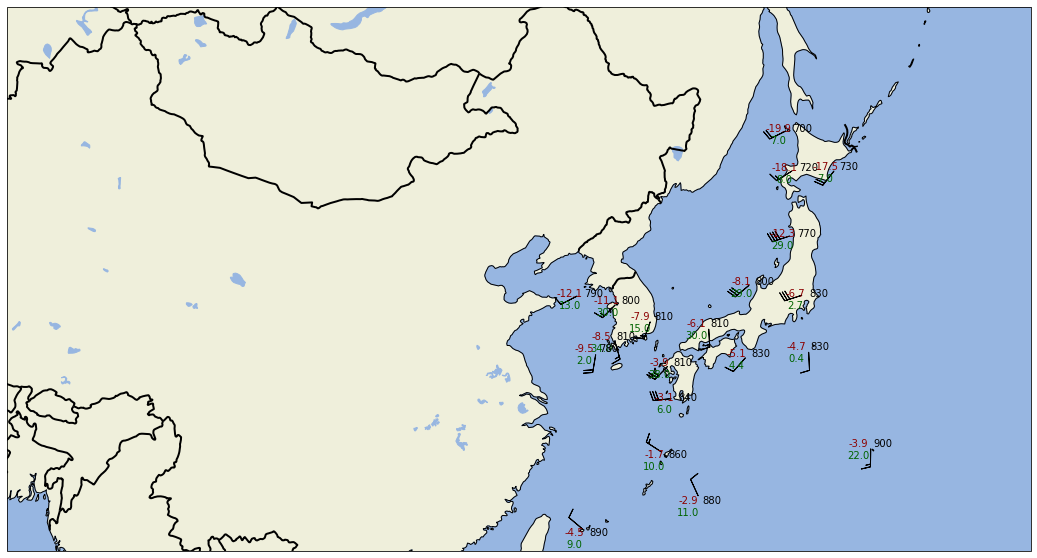

In [5]:
proj = ccrs.LambertConformal(central_longitude=120, central_latitude=35,
                             standard_parallels=[35])
custom_layout = StationPlotLayout()
custom_layout.add_barb('eastward_wind', 'northward_wind', units='knots', length=6)
custom_layout.add_value('W', 'air_temperature', fmt='.1f', units='degC', color='darkred', fontsize=10)
custom_layout.add_value('SW', 'dew_diff', fmt='.1f', units='delta_degC',
                        color='darkgreen', fontsize=10)
custom_layout.add_value('E', 'geopotential_height', fmt=lambda v: format(v, '.0f')[1:4], units='m', color='black', fontsize=10)

# Create the figure and an axes set to the projection
plt.rcParams['savefig.dpi'] = 255
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=proj)

# Add some various map elements to the plot to make it recognizable
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS, linewidth=2)

# Set plot bounds
ax.set_extent((90, 150, 20, 50))

#
# Here's the actual station plot
#

# Start the station plot by specifying the axes to draw on, as well as the
# lon/lat of the stations (with transform). We also the fontsize to 12 pt.
stationplot = StationPlot(ax, data['longitude'], data['latitude'],
                          transform=ccrs.PlateCarree(), fontsize=12)

# The layout knows where everything should go, and things are standardized using
# the names of variables. So the layout pulls arrays out of `data` and plots them
# using `stationplot`.
custom_layout.plot(stationplot, data)

plt.show()